<h1 align='center'> Project: Hotel booking demand exploration
    


# <font color='#347b98'> 1. Data source
  

- Collecting data from Kaggle directly with a file consisting with almost 120 thousand row and 32 columns.


- Original source link: https://www.sciencedirect.com/science/article/pii/S2352340918315191


- Kaggle source link: https://www.kaggle.com/jessemostipak/hotel-booking-demand


- Data is kind of clean and nicely structured.

In [2]:
# Imported all packages that are needed for the project

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df = pd.read_csv('path\hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.info() # Check all data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## EDA

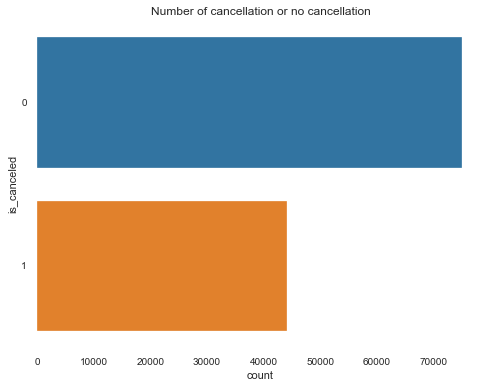

In [8]:
# Compare the numbers between cancelled and not cancelled.

plt.figure(figsize=(8,6))
sns.countplot(y='is_canceled', data=df);
plt.title('Number of cancellation or no cancellation');

- This barchart shows the number sof count of cancelled and not cancelled. Apparently, cancelled is about 60% of not cancelled. Because this columns is target label, we do not need to resample it.

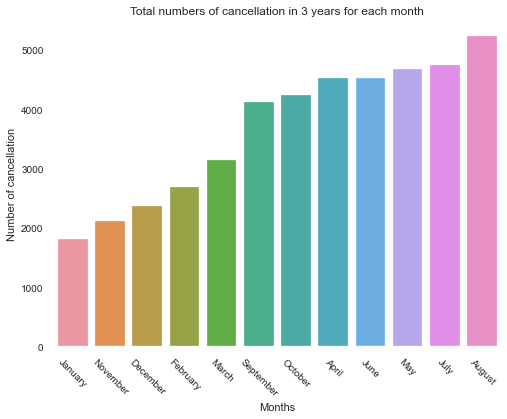

In [9]:
# Describe the cancellation distribution from month to month

sort_months = df.groupby('arrival_date_month')['is_canceled'].sum().sort_values()
df_months_cancelled = pd.DataFrame(sort_months).reset_index()

plt.figure(figsize=(8,6))
pic = sns.barplot(x='arrival_date_month', y='is_canceled',data=df_months_cancelled);
pic.set_title('Total numbers of cancellation in 3 years for each month');
pic.set_xticklabels(labels = df_months_cancelled['arrival_date_month'] ,rotation=-45);
pic.set(xlabel = 'Months', ylabel = 'Number of cancellation');

- in three years from 2015 to 2017, August has most number of cancellation followed by July and May. In january, there is least number of cancellation.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


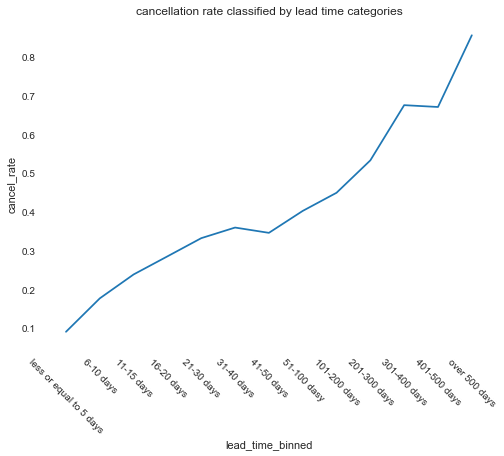

In [10]:
# create linechart to identify the relationship between length of lead time and cancellation rate.

df_copy = df.copy()

bins = [-1,5,10,15,20,30,40,50,100,200,300,400,500,1000]
labels = ['less or equal to 5 days', '6-10 days','11-15 days', '16-20 days','21-30 days','31-40 days','41-50 days',
          '51-100 dasy','101-200 days', '201-300 days','301-400 days', '401-500 days','over 500 days']
df_copy['lead_time_binned'] = pd.cut(df_copy['lead_time'], bins = bins, labels = labels)

lead_time_cancel_count = df_copy.groupby('lead_time_binned')['is_canceled'].count()
lead_time_cancel_count = pd.DataFrame(lead_time_cancel_count).reset_index()

df_cancel = df_copy[df_copy['is_canceled'] == 1]
df_cancel = df_cancel.groupby('lead_time_binned')['is_canceled'].count()
df_cancel = pd.DataFrame(df_cancel).reset_index()

df_cancel_with_total = df_cancel.merge(lead_time_cancel_count, how='left',on='lead_time_binned')
df_cancel_with_total = df_cancel_with_total.rename(columns = {'is_canceled_x':'number_cancel','is_canceled_y':'total_number'})

df_cancel_with_total['cancel_rate'] = df_cancel_with_total['number_cancel'] / df_cancel_with_total['total_number']

plt.figure(figsize=(8,6))
pic_2 = sns.lineplot(x='lead_time_binned', y='cancel_rate', data=df_cancel_with_total, palette = 'RdBu_r');
pic_2.set_xticklabels(labels = df_cancel_with_total['lead_time_binned'], rotation=-45);
pic_2.set_title('cancellation rate classified by lead time categories');

- Binning the lead time into couple segments to reduce categories and easily to see the trend of cancellation ratio(# of cancellation / total # of reservation). And no doubt that with longer lead time, more possible consumers will cancel their reservations. The period from lead time 31-50 days and 301 to 500 days have two flat rate as cancel rates keep stable and even drops a bit.

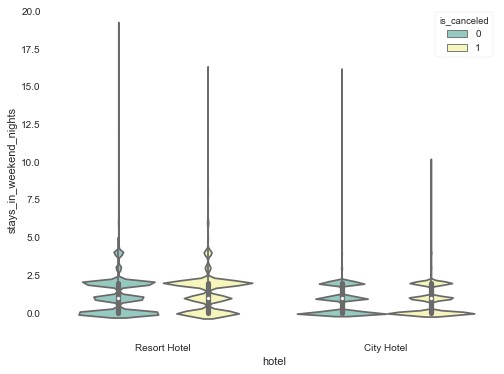

In [11]:
# Indicate differences between hotel types with cancellation for stays in weekend nights.

plt.figure(figsize=(8,6))
sns.violinplot(x='hotel', y='stays_in_weekend_nights',data= df, hue='is_canceled',palette="Set3");

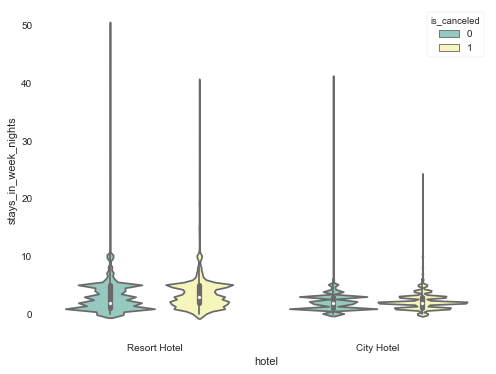

In [12]:
# # Indicate differences between hotel types with cancellation for stays in week nights.

plt.figure(figsize=(8,6))
sns.violinplot(x='hotel', y='stays_in_week_nights',data= df, hue='is_canceled',palette="Set3");

- Above two violin graphs show two types of hotels has different cancellation distribution on week nights and weekend nights.
    - median (a white dot on the violin plot)
    - interquartile range (the black bar in the center of violin)
    - the lower/upper adjacent values (the black lines stretched from the bar) is boundary of how we tell outliers.


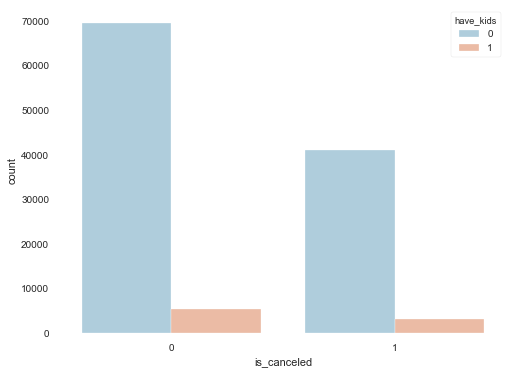

In [13]:
# Cancellation can be related to whether adults have babies and  children or not.

def have_kids(series_1, series_2):
    lst = []
    for i in range(len(series_1)):
        if series_1[i] == 0 & series_2[i] == 0:
            lst.append(0)
        else:
            lst.append(1)
    return lst

df_cy = df.copy()
df_cy['have_kids'] = pd.Series(have_kids(df['children'], df['babies']))

plt.figure(figsize=(8,6));
sns.countplot(x='is_canceled', hue='have_kids',data=df_cy, palette='RdBu_r');

- Create a new feature showing if adults travel with babies or children or both. As we can see the ratio of cancelled or not seems not have a really strong realtionship with this new feature.

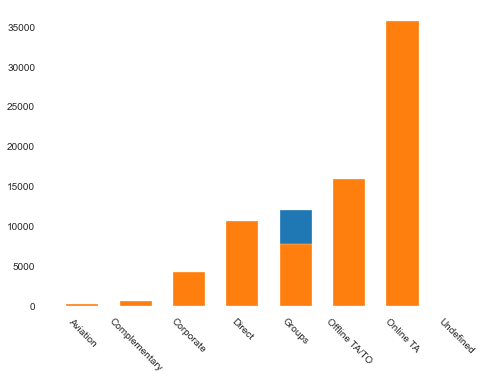

In [14]:
labels = ['Aviation','Complementary','Corporate','Direct','Groups','Offline TA/TO','Online TA','Undefined']

cancelled = df_cy[df_cy['is_canceled']==1].groupby('market_segment')['is_canceled'].value_counts().to_numpy()

not_cancelled = df_cy[df_cy['is_canceled']==0][['market_segment', 'is_canceled']] \
.append({'market_segment': 'Undefined', 'is_canceled': 0}, ignore_index=True) \
.groupby('market_segment')['is_canceled'].value_counts()
not_cancelled['Undefined'] = 0
not_cancelled.to_numpy()

width = 0.6

fig, ax = plt.subplots()

plt.xticks(rotation=-45)
ax.bar(labels, cancelled, width, label='Cancelled');
ax.bar(labels,not_cancelled, width, label='Not cancelled');

- Above chart should be a stack barplot showing total numbers of cancelled and not cancelled regarding to different market segments, but I cannot figure out that for now.

- next couple cells are codes prepared to plot stack barplot. Because I have not figured out how to achieve it, so I just left them as a code reminder.

In [ ]:
cancelled = df_cy[df_cy['is_canceled']==1].groupby('market_segment')['is_canceled'].value_counts()#.to_numpy()
cancelled

In [ ]:
not_cancelled= df_cy[df_cy['is_canceled']==0].groupby('market_segment')['is_canceled'].value_counts()# \
                #.append(pd.Series([0],index=['Undefined']))#.to_numpy()
not_cancelled

#.reindex(df_cy['market_segment'].unique(), fill_value=0)

In [ ]:
not_cancelled = df_cy[df_cy['is_canceled']==0][['market_segment', 'is_canceled']] \
.append({'market_segment': 'Undefined', 'is_canceled': 0}, ignore_index=True) \
.groupby('market_segment')['is_canceled'].value_counts()
not_cancelled['Undefined'] = 0
not_cancelled.to_numpy()

In [ ]:
cancelled = df_cy[df_cy['is_canceled']==1].groupby('market_segment')['is_canceled'].value_counts().to_numpy()
cancelled

In [ ]:
df_cy[df_cy['is_canceled']==0]['market_segment'].value_counts().append(pd.Series([0],index=['Undefined']))#.to_numpy()

In [ ]:
df_cy[df_cy['is_canceled']==1]['market_segment'].value_counts()#.to_numpy()

In [ ]:
list(set(df_cy['market_segment'].values))

## Missing Values Handling

In [15]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         


- As we can see, there are many missing values but all distributed in three columns.
- Delete agent and company directly because these are IDs for both columns.
- For country, delete it for now because we cannot judge customers whether they will cancel the reservation by where they are from.
- Children column has 4 missing values, it takes a very small percentage of all values, will fill it with zero.


In [16]:
df_cop = df.copy()
df_cop = df_cop.drop(columns = ['company','agent','country','reservation_status','reservation_status_date'])
df_cop['children'].fillna(value=0, inplace=True)
df_cop.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

## Check correlation of numerical variables with ''Is_canceled'' column

As shown below, 'arrival_date_week_number', 'children', 'stays_in_weekend_nights' and 'arrival_date_day_of_month' are less correlated with cancellation.

Considered some of thses columns can be converted and be used for creating new features. I will feature engineer some of them later on.

In [17]:
df_cop.corr()['is_canceled'].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005036
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

## Feature Engineering

- Convert categorical variables to numerical variables by One-hot encoding. (Not considering using label encoder because there is not variables have no ordinal relationship).


- Creating new features based on existing features.

In [18]:
# Create a columns called lead time binned to split lead time into groups.

bins = [-1,5,10,15,20,30,40,50,100,200,300,400,500,1000]
labels = ['less or equal to 5 days', '6-10 days','11-15 days', '16-20 days','21-30 days',
          '31-40 days','41-50 days','51-100 dasy','101-200 days', '201-300 days','301-400 days', 
          '401-500 days','over 500 days']
df_cop['lead_time_binned'] = pd.cut(df_cop['lead_time'], bins = bins, labels = labels)

In [19]:
df_cop = pd.get_dummies(columns = ['hotel','arrival_date_month','meal','market_segment',
                                   'distribution_channel','lead_time_binned','deposit_type','customer_type']
                        ,data=df_cop,drop_first=True)
df_cop

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,lead_time_binned_101-200 days,lead_time_binned_201-300 days,lead_time_binned_301-400 days,lead_time_binned_401-500 days,lead_time_binned_over 500 days,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,27,1,0,0,2,0.0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,737,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
119386,0,102,2017,35,31,2,5,3,0.0,0,...,1,0,0,0,0,0,0,0,1,0
119387,0,34,2017,35,31,2,5,2,0.0,0,...,0,0,0,0,0,0,0,0,1,0
119388,0,109,2017,35,31,2,5,2,0.0,0,...,1,0,0,0,0,0,0,0,1,0


In [20]:
# create a feature called family size contain all people.

df_cop['family_size'] = df_cop['adults'] + df_cop['babies'] + df_cop['children']

# to cretae a column which shows if reserved room type matches assigned room type, 
# '1' means matches, '0' means not matches.

def match_type(s1,s2):
    lst = []
    for (m, n) in zip(range(len(s1)), range(len(s2))):
        if s1[m] == s2[n]:
            lst.append(1)
        else:
            lst.append(0)
    return lst

df_cop['room_type_matches'] = match_type(df_cop['reserved_room_type'], df_cop['assigned_room_type'])
dff = df_cop

In [21]:
dff = dff.drop(columns=['reserved_room_type','assigned_room_type'])


In [22]:
dff = dff.drop(columns = ['deposit_type_Non Refund'])
dff

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,lead_time_binned_201-300 days,lead_time_binned_301-400 days,lead_time_binned_401-500 days,lead_time_binned_over 500 days,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,family_size,room_type_matches
0,0,342,2015,27,1,0,0,2,0.0,0,...,0,1,0,0,0,0,1,0,2.0,1
1,0,737,2015,27,1,0,0,2,0.0,0,...,0,0,0,1,0,0,1,0,2.0,1
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,1,0,1.0,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,1,0,1.0,1
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,1,0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,...,0,0,0,0,0,0,1,0,2.0,1
119386,0,102,2017,35,31,2,5,3,0.0,0,...,0,0,0,0,0,0,1,0,3.0,1
119387,0,34,2017,35,31,2,5,2,0.0,0,...,0,0,0,0,0,0,1,0,2.0,1
119388,0,109,2017,35,31,2,5,2,0.0,0,...,0,0,0,0,0,0,1,0,2.0,1


## machine learning

In [24]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 63 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_year               119390 non-null  int64  
 3   arrival_date_week_number        119390 non-null  int64  
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119390 non-null  float64
 9   babies                          119390 non-null  int64  
 10  is_repeated_guest               119390 non-null  int64  
 11  previous_cancellations          119390 non-null  int64  
 12  previous_booking

## Baseline Model - XGBoost / Logistic Regression

In [26]:
# Baseline1 - XGBoost

from xgboost import XGBClassifier
X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     50361
           1       0.87      0.76      0.81     29630

    accuracy                           0.87     79991
   macro avg       0.87      0.84      0.85     79991
weighted avg       0.87      0.87      0.86     79991

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     24805
           1       0.84      0.73      0.78     14594

    accuracy                           0.85     39399
   macro avg       0.85      0.82      0.83     39399
weighted avg       0.85      0.85      0.85     39399



In [28]:
# Baseline2 - Logistic regression

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,  stratify = y)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

C:\Users\Jessey\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.80      0.87      0.83     50361
           1       0.74      0.62      0.67     29630

    accuracy                           0.78     79991
   macro avg       0.77      0.74      0.75     79991
weighted avg       0.77      0.78      0.77     79991

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     24805
           1       0.74      0.61      0.67     14594

    accuracy                           0.78     39399
   macro avg       0.76      0.74      0.75     39399
weighted avg       0.77      0.78      0.77     39399



In [29]:
lr.coef_[0]

array([ 6.32356406e-03, -1.08592839e-03, -2.94961585e-03,  2.72869355e-04,
       -8.26577451e-02,  6.03125843e-02,  5.31932591e-02, -2.26435257e-02,
       -1.85067043e-02, -5.76460368e-02,  5.92486247e-01, -3.24413398e-01,
       -7.10134962e-01,  2.34043367e-04,  4.95690047e-03, -3.34328618e-01,
       -1.22360945e+00, -3.45969734e-01, -6.34727640e-02,  6.36140216e-02,
        4.66416752e-02,  5.19349068e-03, -1.05028393e-01, -4.95115436e-03,
       -7.28560525e-03, -2.54187697e-02,  2.23779709e-02,  2.14066114e-02,
       -1.60336081e-02,  2.76521517e-02, -1.72071503e-01,  6.47575006e-02,
       -1.51101544e-02, -5.01267325e-03, -3.44482807e-02, -2.69037890e-01,
        3.80317499e-01, -2.05474536e-01,  1.34813158e-01,  0.00000000e+00,
       -2.74255032e-01, -3.87051574e-03,  3.18861685e-01,  3.76061247e-04,
       -5.70593695e-02, -1.15232766e-02,  2.08011002e-02,  6.27900388e-02,
        8.35285280e-02,  4.34668148e-02,  2.41004041e-01,  7.72718797e-02,
       -4.74284956e-02, -

In [30]:
pic = pd.DataFrame(lr.coef_[0], index=X.columns).sort_values(by=[0]).reset_index()
pic

,index,0
0,total_of_special_requests,-1.223609
1,booking_changes,-0.710135
2,customer_type_Transient-Party,-0.531080
3,hotel_Resort Hotel,-0.345970
4,required_car_parking_spaces,-0.334329
...,...,...
57,distribution_channel_TA/TO,0.318862
58,market_segment_Groups,0.380317
59,room_type_matches,0.528247
60,previous_cancellations,0.592486


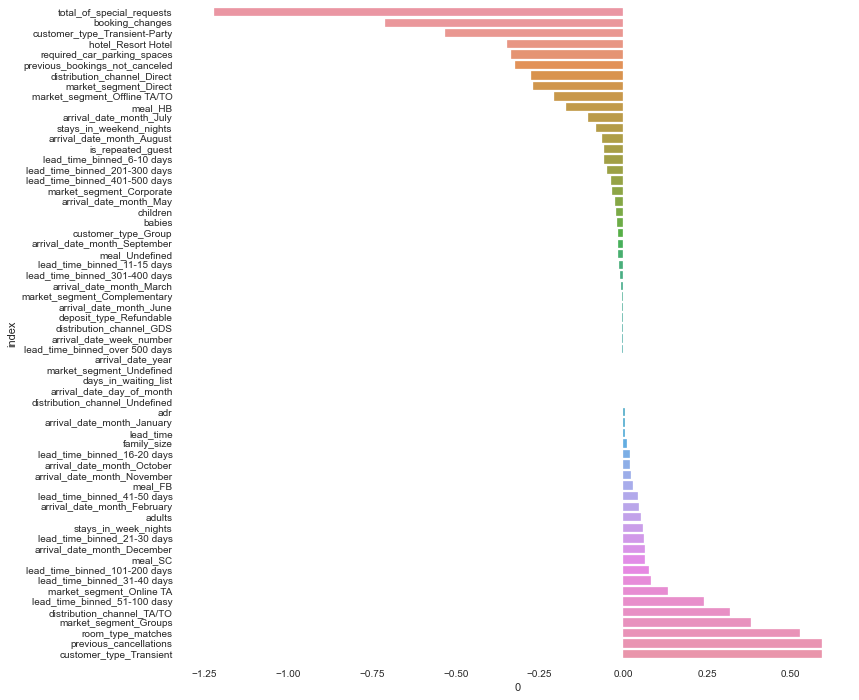

In [31]:
# plot the coeff of each variables

plt.figure(figsize=(12,12));
sns.barplot(y='index', x=0,data=pic);

- Bar chart above shows the distribution of coeff_. It is evident that total of special rquest have a significantly negative effect to the model, followed by booking changes. For positive coef_, previous_cancellation and room type matches affect mostly to the model.

# Use GridSearch to find best hyper parameters for each model then use pipeline to double check how each model perform

## Logistic Regression

In [37]:
# Use gridsearch to find best hyper parameters

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param = {
    'penalty':['l1','l2']
}

lr = LogisticRegression()

gs = GridSearchCV(lr, param, cv=5, scoring='f1', n_jobs=-1, verbose=2)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished
C:\Users\Jessey\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2']}, scoring='f1', verbose=2)

In [38]:
gs.best_params_

{'penalty': 'l2'}

In [39]:
gsbm = gs.best_estimator_

y_train_pred = gsbm.predict(X_train_scaled)
y_pred = gsbm.predict(X_test_scaled)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85     50361
           1       0.76      0.67      0.71     29630

    accuracy                           0.80     79991
   macro avg       0.79      0.77      0.78     79991
weighted avg       0.80      0.80      0.80     79991

              precision    recall  f1-score   support

           0       0.82      0.87      0.84     24805
           1       0.75      0.66      0.71     14594

    accuracy                           0.79     39399
   macro avg       0.78      0.77      0.77     39399
weighted avg       0.79      0.79      0.79     39399



In [41]:
# use pipeline to apply LR to predict cancellation.

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('LogisticRegression', LogisticRegression(penalty = 'l2'))
])

scores = cross_validate(pipe, X_train_scaled, y_train, cv=5, scoring=['f1', 'accuracy'])

print(pd.DataFrame(scores))

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

   fit_time  score_time   test_f1  test_accuracy
0  0.853253    0.027927  0.000337       0.629539
1  1.168874    0.018964  0.000337       0.629579
2  1.024745    0.026927  0.000000       0.629579
3  1.086973    0.017953  0.000000       0.629579
4  1.027444    0.015622  0.000337       0.629579
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     50361
           1       0.76      0.67      0.71     29630

    accuracy                           0.80     79991
   macro avg       0.79      0.77      0.78     79991
weighted avg       0.80      0.80      0.80     79991

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     24805
           1       0.75      0.66      0.71     14594

    accuracy                           0.79     39399
   macro avg       0.78      0.77      0.77     39399
weighted avg       0.79      0.79      0.79     39399



- As we can see, compared to baseline models, after scaling and cross validating, f1-score, precision and recall rate increase significantly. model has low bias and low variance. Seems like LR is likely to be a good model for this case.

## Decision Tree

In [42]:
# Use gridsearch to find best hyper parameters

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41, stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param = {
    'criterion':['gini','entropy'],
    'max_depth':[5,10,15,20,25,30],
    'min_samples_split': [2,3,4,5,8.10],
    'min_samples_leaf':[1,2,3,4,5,6],
    'max_features' :["sqrt", "log2"]
}

dt = DecisionTreeClassifier()

gs = GridSearchCV(dt, param, cv=5, scoring='f1', n_jobs=-1, verbose=2)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  4.5min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 8.1]},
             scoring='f1', verbose=2)

In [43]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [44]:
gsbm = gs.best_estimator_

y_train_pred = gsbm.predict(X_train_scaled)
y_pred = gsbm.predict(X_test_scaled)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     50361
           1       0.91      0.81      0.86     29630

    accuracy                           0.90     79991
   macro avg       0.90      0.88      0.89     79991
weighted avg       0.90      0.90      0.90     79991

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     24805
           1       0.79      0.71      0.75     14594

    accuracy                           0.82     39399
   macro avg       0.81      0.80      0.80     39399
weighted avg       0.82      0.82      0.82     39399



In [46]:
# use pipeline to apply DT to predict cancellation.

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pipe = Pipeline([
    #('scaling', StandardScaler()),
    ('DecisionTree', DecisionTreeClassifier(criterion= 'entropy',max_depth= 25,max_features= 'sqrt',min_samples_leaf= 1,min_samples_split= 3))
])

scores = cross_validate(pipe, X_train_scaled, y_train, cv=5, scoring=['f1', 'accuracy'])

print(pd.DataFrame(scores))

pipe.fit(X_train_scaled, y_train)

y_train_pred = pipe.predict(X_train_scaled)
y_pred = pipe.predict(X_test_scaled)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

   fit_time  score_time   test_f1  test_accuracy
0  0.180295    0.015622  0.747475       0.820301
1  0.204487    0.004341  0.748264       0.823228
2  0.211092    0.013998  0.740734       0.813727
3  0.183517    0.005294  0.742857       0.814914
4  0.179652    0.015659  0.739579       0.815289
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     50361
           1       0.90      0.82      0.86     29630

    accuracy                           0.90     79991
   macro avg       0.90      0.88      0.89     79991
weighted avg       0.90      0.90      0.90     79991

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     24805
           1       0.79      0.73      0.76     14594

    accuracy                           0.83     39399
   macro avg       0.82      0.81      0.81     39399
weighted avg       0.82      0.83      0.83     39399



- Decision Tree is a model that is easily to reach overfitting. Not exception for this case, DT gets a high score but decreases 7% in test set. But compared to LR, DT seems have a better performce in the whole.

## Random Forest

In [47]:
# Use gridsearch to find best hyper parameters

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param = {
#     'criterion':['gini','entropy'],
    'max_depth':[10,20,30,40,50,None],
    'n_estimators':[100,200,300,400]
#     'min_samples_split': [2,3,4,5,8.10],
#     'min_samples_leaf':[1,2,3,4,5,6],
#     'max_features' :["sqrt", "log2"]
}

rf = RandomForestClassifier()

gs = GridSearchCV(rf, param, cv=5, scoring='f1', n_jobs=-1, verbose=2)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 22.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, None],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1', verbose=2)

In [48]:
gs.best_params_

{'max_depth': None, 'n_estimators': 300}

In [49]:
gsbm = gs.best_estimator_

y_train_pred = gsbm.predict(X_train_scaled)
y_pred = gsbm.predict(X_test_scaled)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     50361
           1       0.99      0.99      0.99     29630

    accuracy                           0.99     79991
   macro avg       0.99      0.99      0.99     79991
weighted avg       0.99      0.99      0.99     79991

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24805
           1       0.86      0.76      0.81     14594

    accuracy                           0.87     39399
   macro avg       0.87      0.84      0.85     39399
weighted avg       0.87      0.87      0.86     39399



In [51]:
# use pipeline to apply RF to predict cancellation.

X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pipe = Pipeline([
    #('scaling', StandardScaler()),
    ('RandomForest', RandomForestClassifier(n_estimators = 300))
])

scores = cross_validate(pipe, X_train_scaled, y_train, cv=5, scoring=['f1', 'accuracy'])

print(pd.DataFrame(scores))

pipe.fit(X_train_scaled, y_train)

y_train_pred = pipe.predict(X_train_scaled)
y_pred = pipe.predict(X_test_scaled)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

    fit_time  score_time   test_f1  test_accuracy
0  35.239842    1.475039  0.808621       0.866242
1  35.523993    1.652988  0.801824       0.861483
2  50.828132    2.529397  0.806426       0.865171
3  70.994780    2.700570  0.803745       0.863733
4  64.779819    2.729843  0.802691       0.862483
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     50361
           1       0.99      0.99      0.99     29630

    accuracy                           0.99     79991
   macro avg       0.99      0.99      0.99     79991
weighted avg       0.99      0.99      0.99     79991

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24805
           1       0.86      0.77      0.81     14594

    accuracy                           0.87     39399
   macro avg       0.87      0.85      0.85     39399
weighted avg       0.87      0.87      0.87     39399



- Random Forest gets a better socre in training set than Decision Tree. But it has the same problem - overfitting.

## Interpretation - Permutation Importance

In [60]:
X = dff.drop(columns='is_canceled')
y = dff['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('LogisticRegression', LogisticRegression(penalty = 'l2'))
])

scores = cross_validate(pipe, X_train_scaled, y_train, cv=5, scoring=['f1', 'accuracy'])

print(pd.DataFrame(scores))

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(pipe, random_state=1)

perm.fit(X_train, y_train)

eli5.show_weights(perm, feature_names=X_train.columns.tolist())

   fit_time  score_time  test_f1  test_accuracy
0  0.890583    0.025932      0.0       0.629602
1  1.021268    0.019947      0.0       0.629516
2  1.038223    0.019948      0.0       0.629391
3  0.984366    0.019947      0.0       0.629579
4  1.222729    0.019947      0.0       0.629579
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     50361
           1       0.76      0.67      0.71     29630

    accuracy                           0.80     79991
   macro avg       0.79      0.77      0.78     79991
weighted avg       0.79      0.80      0.79     79991

              precision    recall  f1-score   support

           0       0.82      0.87      0.85     24805
           1       0.76      0.67      0.71     14594

    accuracy                           0.80     39399
   macro avg       0.79      0.77      0.78     39399
weighted avg       0.80      0.80      0.80     39399



Weight,Feature
0.1756 ± 0.0023,arrival_date_week_number
0.0532 ± 0.0015,total_of_special_requests
0.0469 ± 0.0008,lead_time_binned_101-200 days
0.0454 ± 0.0010,arrival_date_month_October
0.0433 ± 0.0010,arrival_date_month_August
0.0421 ± 0.0013,arrival_date_month_September
0.0413 ± 0.0009,customer_type_Transient
0.0370 ± 0.0012,lead_time_binned_51-100 dasy
0.0321 ± 0.0017,arrival_date_month_July
0.0277 ± 0.0006,arrival_date_month_December


 - Even Logistic Refression model does not have the highest score in both training and testing sets but it is the most balanced model that has low bias and variance. the other two have overfitting issues. Because of time limits, three models can be improved by doing more jobs on EDA and feature engineering to reduce variance in two tree based models. 
 
 
 - From permutation importance chart, we can notice that arrival date week numbers affects most to the LR model followed by number of special request, which means arrival date of week are most predictive feature affecting the model. Second comes number of special requests which are shown on coef_ chart as well indicating it put most negative impact on baseline model(LR).